In [1]:
import pyro
import torch
import normflows as nf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import yaml
import corner
import random
import pandas as pd
from collections import defaultdict
import numpy as np
mpl.rcParams["figure.dpi"] = 100

from grad_june import Runner

#torch.autograd.detect_anomaly(check_nan=True)

In [2]:
device = "cpu"

In [3]:
def set_random_seed(seed=999):
    """
    Sets global seeds for testing in numpy, random, and numbaized numpy.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    return
#set_random_seed()

In [4]:
def plot_posterior(nfm, param_names, lims=(0,2)):
    posteriors = nfm.sample(10000)
    samples = posteriors[0].cpu().detach().numpy()
    samples = np.where(~np.isnan(samples), samples, 0)
    samples = np.where(~np.isinf(samples), samples, 0)
    samples = np.where(np.abs(samples) < 5, samples, 0)
    f = corner.corner(samples, 
                      labels = param_names, 
                      smooth=2, 
                      show_titles=True,
                      bins=30,
                      range = [lims for i in range(len(param_names))])
    #f.savefig(f"./flow_results/posteriors/posterior_{it:03d}.png", dpi=150, facecolor='white')
    return

/var/folders/s5/jmvhvqns52q3ysypfjykg6y40000gr/T/ipykernel_99426/870570908.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deaths_df = deaths_df.groupby("date").sum()["daily_deaths"].to_frame()


<AxesSubplot: >

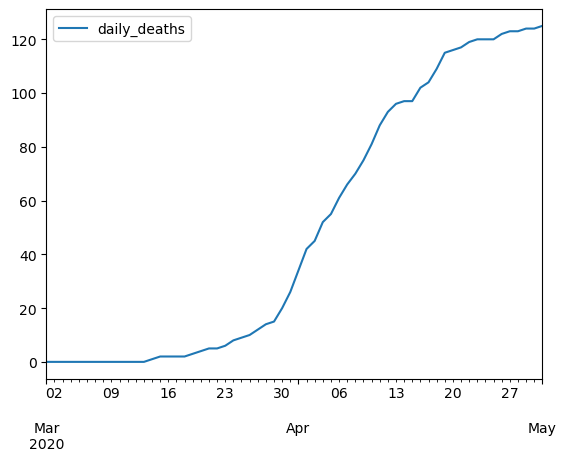

In [5]:
deaths_df = pd.read_csv("../data/deaths_by_lad.csv")
deaths_df = deaths_df.loc[deaths_df.area_name == "Camden"]
deaths_df = deaths_df.groupby("date").sum()["daily_deaths"].to_frame()
deaths_df.index = pd.to_datetime(deaths_df.index)

date_range = pd.date_range(start="2020-03-01", end="2020-05-01")
data_df = pd.DataFrame(index=date_range)
data_df["daily_deaths"] = 0
for date in date_range:
    if date in deaths_df.index:
        data_df.loc[date, "daily_deaths"] = deaths_df.loc[date, "daily_deaths"]
data_df = data_df.cumsum()
data_df.plot()


In [6]:
params = yaml.safe_load(open("../configs/best_run.yaml"))
params_to_calibrate = ["household", "school", "company", "university", "care_home", "care_visit", "leisure"]
n_params = len(params_to_calibrate)
params["timer"]["total_days"] = len(data_df) - 1
params["timer"]["initial_day"] = "2020-03-01"
params["system"]["device"] = device
params["data_path"] = "/Users/arnull/code/gradabm-june/worlds/data_camden.pkl"
#params["data_path"] = "/cosma7/data/dp004/dc-quer1/torch_june_worlds/data_camden.pkl"
runner = Runner.from_parameters(params)
runner()
test_deaths = runner.data['results']['daily_deaths']

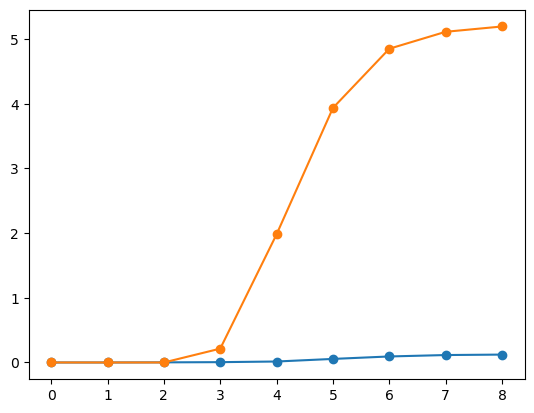

In [7]:
true_data = torch.tensor(data_df.values, device=device).flatten() / 1000 # / runner.n_agents * 100
plt.plot(true_data[::7].cpu(), "o-")
plt.plot(test_deaths[::7].cpu() / 1000, "o-")
#plt.yscale("log")

In [8]:
prior = torch.distributions.Normal(torch.ones(n_params, device=device), torch.ones(n_params, device=device))

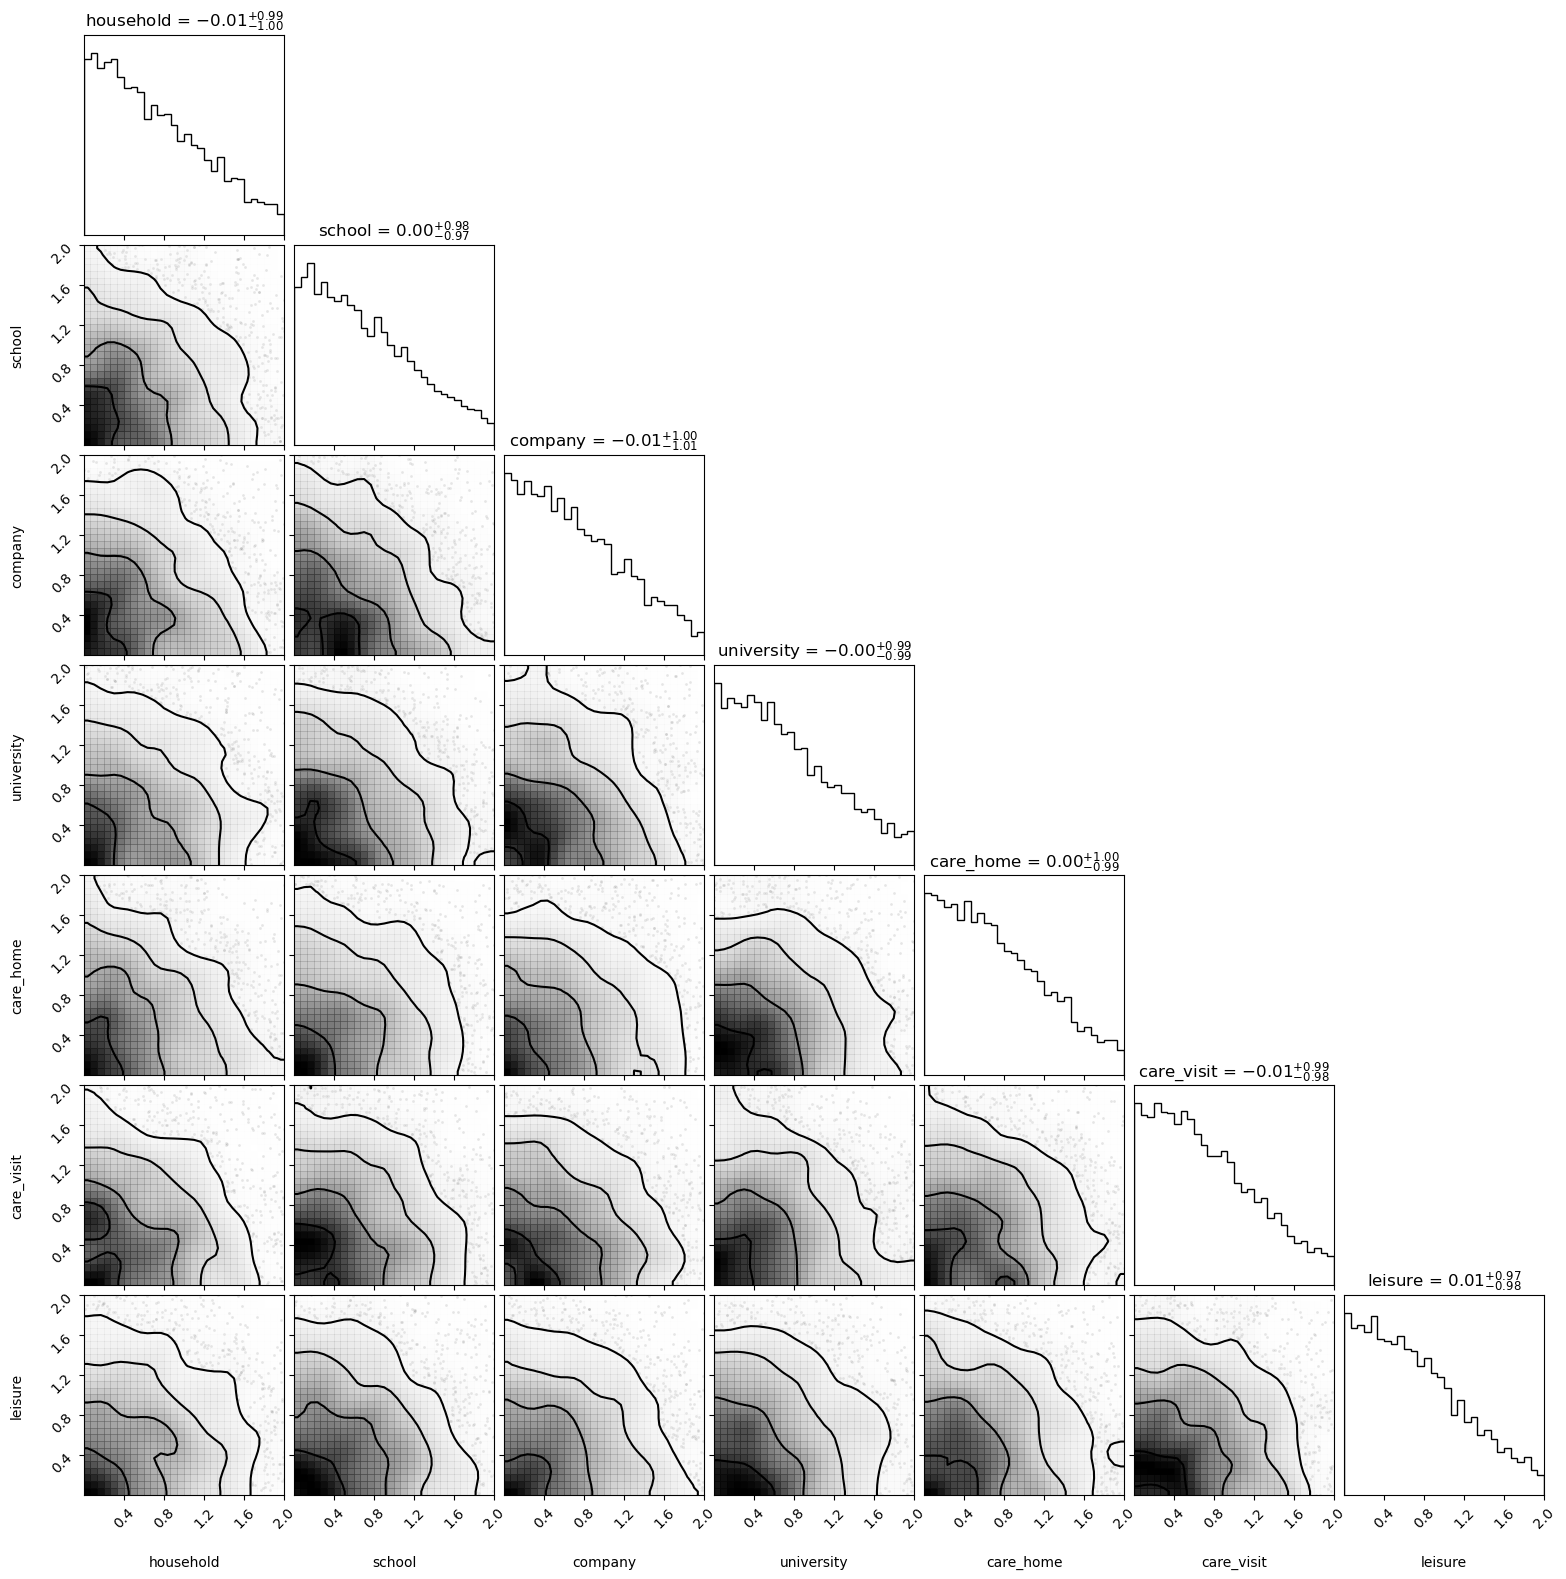

In [9]:
# Set up model

# Define flows
K = 8

latent_size = n_params
hidden_units = 64
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set prior and q0
q0 = nf.distributions.DiagGaussian(n_params, trainable=False)

# Construct flow model
flow = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
flow = flow.to(device)

plot_posterior(flow, param_names = params_to_calibrate)
plt.show()

In [10]:
def run_model(runner, sample):
    #print(sample)
    sample = sample.flatten()
    for (j, name) in enumerate(params_to_calibrate):
        if name == "log_fraction_initial_cases":
            runner.log_fraction_initial_cases = torch.minimum(torch.tensor(0.0), sample[j])
        elif name == "leisure":
            for _name in ["pub", "grocery", "gym", "cinema"]:
                runner.model.infection_networks.networks[_name].log_beta = sample[j]
        else:
            runner.model.infection_networks.networks[name].log_beta = sample[j]
    _ = runner()
    daily_deaths = runner.data["results"]["daily_deaths"] / 1000 #/ runner.n_agents * 100
    return daily_deaths

def get_forecast_score(flow, true_data, loss_fn, n_samples=5):
    loss = 0.0
    for i in range(n_samples):
        sample, lp = flow.sample()
        daily_deaths = run_model(runner, sample)
        print(daily_deaths)
        print(true_data)
        print("--")
        loss_i = loss_fn(daily_deaths, true_data)
        #loss_i.backward()
        loss += loss_i
    return loss / n_samples

def get_regularisation(flow, n_samples=5):
    samples, flow_lps = flow.sample(n_samples)
    prior_lps = prior.log_prob(samples).sum(1)
    kl = torch.mean(flow_lps - prior_lps)
    return kl


In [11]:
losses = defaultdict(list)
best_loss = np.inf

In [12]:
# Train model

parameters_to_optimize = list(flow.parameters())
print(sum([len(a) for a in parameters_to_optimize]))
optimizer = torch.optim.Adam(parameters_to_optimize, lr=1e-3)
loss_fn = torch.nn.MSELoss(reduction="mean")


n_epochs = 10000
n_samples_per_epoch = 5
n_samples_reg = 10


w = 0.0 #torch.tensor(1.0, requires_grad=True)

iterator = tqdm(range(n_epochs))

for it in iterator:
    optimizer.zero_grad()
    forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
    reglrise_loss = get_regularisation(flow=flow, n_samples=n_samples_reg)
    loss = forecast_loss  + w * reglrise_loss
    losses["forecast_train"].append(forecast_loss.item())
    losses["reglrise_train"].append(reglrise_loss.item())
    #print(loss)
    if torch.isnan(loss):
        print("loss is nan!")
        break
    loss.backward()

    optimizer.step()
    if loss.item() < best_loss:
        torch.save(flow.state_dict(), "./best_model_data.pth")
        best_loss = loss.item()
    
    #with torch.no_grad():
    #    val_forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
    #    val_reglrise_loss = get_regularisation(flow=flow, n_samples=n_samples_reg)
    #    val_loss = val_forecast_loss + w * val_reglrise_loss
    #    
    #    losses["forecast_val"].append(val_forecast_loss.item())
    #    losses["reglrise_val"].append(val_reglrise_loss.item())
#
    #    if val_loss.item() < best_loss:
    #        torch.save(flow.state_dict(), "./best_model_data.pth")
    #        best_loss = val_loss.item()
    #    iterator.set_postfix({"fl":forecast_loss.item(), 
    #                          "rl":reglrise_loss.item(), 
    #                          "val loss":val_loss.item(), 
    #                          "best val loss":best_loss})
    df = pd.DataFrame(losses)
    df.to_csv("./losses_data.csv")

8144


  0%|                                                                                                                                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 2.0000e-03, 7.0000e-03,
        1.4000e-02, 2.4000e-02, 4.5000e-02, 8.3000e-02, 1.4500e-01, 2.5000e-01,
        3.7600e-01, 5.3200e-01, 7.1400e-01, 9.2600e-01, 1.1880e+00, 1.4650e+00,
        1.7540e+00, 2.0460e+00, 2.3430e+00, 2.6280e+00, 2.9070e+00, 3.1310e+00,
        3.3670e+00, 3.5940e+00, 3.7810e+00, 3.9420e+00, 4.0860e+00, 4.2170e+00,
        4.3220e+00, 4.4310e+00, 4.5240e+00, 4.6130e+00, 4.6730e+00, 4.7220e+00,
        4.7690e+00, 4.8100e+00, 4.8410e+00, 4.8690e+00, 4.8910e+00, 4.9200e+00,
        4.9300e+00, 4.9470e+00, 4.9650e+00, 4.9700e+00, 4.9740e+00, 4.9830e+00,
        4.9860e+00, 4.9910e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|                                                                                                                                                                                                                                                                                 | 1/10000 [01:39<276:48:41, 99.66s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 3.0000e-03,
        3.0000e-03, 7.0000e-03, 1.7000e-02, 5.1000e-02, 7.8000e-02, 1.2300e-01,
        1.9100e-01, 2.9500e-01, 4.1100e-01, 5.9400e-01, 7.6500e-01, 9.5900e-01,
        1.1660e+00, 1.4200e+00, 1.6470e+00, 1.8700e+00, 2.1250e+00, 2.3800e+00,
        2.6120e+00, 2.8270e+00, 3.0240e+00, 3.1750e+00, 3.3340e+00, 3.4720e+00,
        3.6110e+00, 3.7320e+00, 3.8330e+00, 3.9330e+00, 4.0170e+00, 4.0760e+00,
        4.1290e+00, 4.1720e+00, 4.2030e+00, 4.2480e+00, 4.2710e+00, 4.2880e+00,
        4.3020e+00, 4.3220e+00, 4.3290e+00, 4.3380e+00, 4.3470e+00, 4.3510e+00,
        4.3590e+00, 4.3650e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|                                                                                                                                                                                                                                                                                | 2/10000 [03:20<278:24:08, 100.24s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03, 5.0000e-03,
        1.3000e-02, 2.6000e-02, 5.2000e-02, 8.6000e-02, 1.3000e-01, 2.1900e-01,
        3.0700e-01, 4.5800e-01, 6.4700e-01, 8.5800e-01, 1.0760e+00, 1.2720e+00,
        1.5530e+00, 1.7840e+00, 2.0240e+00, 2.2640e+00, 2.4770e+00, 2.6640e+00,
        2.8420e+00, 2.9730e+00, 3.1330e+00, 3.2540e+00, 3.3690e+00, 3.4590e+00,
        3.5510e+00, 3.6320e+00, 3.7090e+00, 3.7590e+00, 3.8070e+00, 3.8610e+00,
        3.8930e+00, 3.9290e+00, 3.9490e+00, 3.9690e+00, 3.9860e+00, 3.9980e+00,
        4.0100e+00, 4.0200e+00, 4.0260e+00, 4.0370e+00, 4.0450e+00, 4.0490e+00,
        4.0540e+00, 4.0550e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|                                                                                                                                                                                                                                                                                | 3/10000 [05:00<278:32:18, 100.30s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03,
        1.0000e-02, 2.1000e-02, 3.8000e-02, 6.7000e-02, 1.0400e-01, 1.7300e-01,
        2.5800e-01, 3.6400e-01, 5.0200e-01, 6.9900e-01, 8.7800e-01, 1.1430e+00,
        1.3870e+00, 1.6550e+00, 1.9100e+00, 2.1780e+00, 2.4250e+00, 2.6640e+00,
        2.8980e+00, 3.1140e+00, 3.3150e+00, 3.4760e+00, 3.6220e+00, 3.7430e+00,
        3.8650e+00, 3.9610e+00, 4.0520e+00, 4.1320e+00, 4.1870e+00, 4.2580e+00,
        4.3070e+00, 4.3460e+00, 4.3830e+00, 4.4030e+00, 4.4190e+00, 4.4420e+00,
        4.4590e+00, 4.4730e+00, 4.4850e+00, 4.4970e+00, 4.5060e+00, 4.5110e+00,
        4.5180e+00, 4.5220e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|                                                                                                                                                                                                                                                                                | 4/10000 [06:40<278:14:26, 100.21s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e-03, 1.5000e-02,
        3.1000e-02, 5.7000e-02, 9.7000e-02, 1.7500e-01, 2.6500e-01, 4.1000e-01,
        5.7400e-01, 7.6600e-01, 9.7000e-01, 1.2110e+00, 1.4550e+00, 1.6790e+00,
        1.9290e+00, 2.1540e+00, 2.3850e+00, 2.6050e+00, 2.8000e+00, 2.9760e+00,
        3.1670e+00, 3.3150e+00, 3.4810e+00, 3.6150e+00, 3.7230e+00, 3.8130e+00,
        3.8860e+00, 3.9530e+00, 4.0090e+00, 4.0460e+00, 4.0770e+00, 4.1070e+00,
        4.1370e+00, 4.1680e+00, 4.1930e+00, 4.2120e+00, 4.2230e+00, 4.2340e+00,
        4.2430e+00, 4.2520e+00, 4.2570e+00, 4.2630e+00, 4.2650e+00, 4.2710e+00,
        4.2730e+00, 4.2740e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▏                                                                                                                                                                                                                                                                               | 5/10000 [08:20<278:03:34, 100.15s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 3.0000e-03,
        1.1000e-02, 3.0000e-02, 4.2000e-02, 6.7000e-02, 1.0700e-01, 1.6100e-01,
        2.4100e-01, 3.5500e-01, 5.0200e-01, 6.7300e-01, 8.7200e-01, 1.0830e+00,
        1.3310e+00, 1.5980e+00, 1.8400e+00, 2.1020e+00, 2.3890e+00, 2.6660e+00,
        2.9220e+00, 3.1560e+00, 3.3910e+00, 3.6160e+00, 3.8000e+00, 3.9790e+00,
        4.1400e+00, 4.2580e+00, 4.3530e+00, 4.4280e+00, 4.5120e+00, 4.5920e+00,
        4.6440e+00, 4.6920e+00, 4.7300e+00, 4.7750e+00, 4.8150e+00, 4.8470e+00,
        4.8740e+00, 4.8910e+00, 4.9010e+00, 4.9240e+00, 4.9320e+00, 4.9420e+00,
        4.9460e+00, 4.9520e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▏                                                                                                                                                                                                                                                                               | 6/10000 [10:00<278:00:49, 100.15s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03,
        1.0000e-03, 7.0000e-03, 1.3000e-02, 2.1000e-02, 3.0000e-02, 5.5000e-02,
        8.0000e-02, 1.2000e-01, 1.9400e-01, 2.5500e-01, 3.6600e-01, 5.0600e-01,
        6.4400e-01, 8.0700e-01, 1.0320e+00, 1.2460e+00, 1.4820e+00, 1.7140e+00,
        1.9220e+00, 2.1480e+00, 2.3570e+00, 2.5630e+00, 2.7430e+00, 2.9330e+00,
        3.0910e+00, 3.2410e+00, 3.3770e+00, 3.5090e+00, 3.6160e+00, 3.6900e+00,
        3.7710e+00, 3.8210e+00, 3.8780e+00, 3.9270e+00, 3.9660e+00, 4.0070e+00,
        4.0340e+00, 4.0570e+00, 4.0910e+00, 4.1070e+00, 4.1320e+00, 4.1370e+00,
        4.1440e+00, 4.1490e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▏                                                                                                                                                                                                                                                                               | 7/10000 [11:40<277:46:41, 100.07s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 2.0000e-03,
        2.0000e-03, 5.0000e-03, 1.3000e-02, 1.7000e-02, 2.6000e-02, 4.1000e-02,
        7.4000e-02, 1.1800e-01, 1.5800e-01, 2.2500e-01, 3.0900e-01, 4.1300e-01,
        5.4700e-01, 7.0100e-01, 8.7300e-01, 1.0660e+00, 1.2540e+00, 1.4670e+00,
        1.6990e+00, 1.9400e+00, 2.1130e+00, 2.3070e+00, 2.5050e+00, 2.6810e+00,
        2.8310e+00, 2.9640e+00, 3.0900e+00, 3.2060e+00, 3.3050e+00, 3.3810e+00,
        3.4560e+00, 3.5080e+00, 3.5530e+00, 3.5940e+00, 3.6410e+00, 3.6690e+00,
        3.6900e+00, 3.7060e+00, 3.7250e+00, 3.7430e+00, 3.7600e+00, 3.7730e+00,
        3.7870e+00, 3.7960e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▏                                                                                                                                                                                                                                                                               | 8/10000 [13:20<277:46:25, 100.08s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03,
        2.0000e-03, 5.0000e-03, 1.0000e-02, 1.6000e-02, 2.9000e-02, 4.3000e-02,
        6.5000e-02, 1.1500e-01, 1.6900e-01, 2.4500e-01, 3.3100e-01, 4.4000e-01,
        5.8100e-01, 7.5900e-01, 9.2600e-01, 1.1160e+00, 1.3100e+00, 1.5320e+00,
        1.7410e+00, 1.9660e+00, 2.1630e+00, 2.3660e+00, 2.5420e+00, 2.7020e+00,
        2.8630e+00, 2.9920e+00, 3.1280e+00, 3.2250e+00, 3.3200e+00, 3.3960e+00,
        3.4750e+00, 3.5340e+00, 3.5830e+00, 3.6190e+00, 3.6570e+00, 3.6850e+00,
        3.6980e+00, 3.7100e+00, 3.7310e+00, 3.7430e+00, 3.7560e+00, 3.7640e+00,
        3.7680e+00, 3.7750e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▏                                                                                                                                                                                                                                                                               | 9/10000 [15:01<278:25:32, 100.32s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e-03, 2.0000e-03, 3.0000e-03, 3.0000e-03,
        4.0000e-03, 4.0000e-03, 1.1000e-02, 1.6000e-02, 2.8000e-02, 4.8000e-02,
        6.2000e-02, 8.7000e-02, 1.2200e-01, 1.8000e-01, 2.5400e-01, 3.4500e-01,
        4.3800e-01, 5.6400e-01, 6.9900e-01, 8.9100e-01, 1.0710e+00, 1.2470e+00,
        1.4290e+00, 1.6030e+00, 1.7600e+00, 1.9080e+00, 2.0680e+00, 2.2230e+00,
        2.3460e+00, 2.4850e+00, 2.6060e+00, 2.6980e+00, 2.7760e+00, 2.8540e+00,
        2.9260e+00, 2.9910e+00, 3.0430e+00, 3.0840e+00, 3.1270e+00, 3.1580e+00,
        3.1920e+00, 3.2200e+00, 3.2430e+00, 3.2600e+00, 3.2710e+00, 3.2870e+00,
        3.2970e+00, 3.3030e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▎                                                                                                                                                                                                                                                                              | 10/10000 [16:42<278:43:35, 100.44s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0050, 0.0110, 0.0180, 0.0280, 0.0480, 0.0810, 0.1170,
        0.1650, 0.2300, 0.3360, 0.4540, 0.5840, 0.7270, 0.8900, 1.0790, 1.2520,
        1.4390, 1.5670, 1.7570, 1.9190, 2.0840, 2.2130, 2.3640, 2.4960, 2.6070,
        2.6940, 2.7750, 2.8640, 2.9400, 2.9950, 3.0480, 3.0860, 3.1340, 3.1610,
        3.1870, 3.2060, 3.2180, 3.2310, 3.2450, 3.2560, 3.2650, 3.2720],
       grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,
        0.0970, 

  0%|▎                                                                                                                                                                                                                                                                              | 11/10000 [18:23<278:49:32, 100.49s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 2.0000e-03,
        4.0000e-03, 6.0000e-03, 1.0000e-02, 1.6000e-02, 2.0000e-02, 3.1000e-02,
        4.9000e-02, 7.0000e-02, 9.8000e-02, 1.4000e-01, 2.0700e-01, 2.7600e-01,
        3.7500e-01, 4.7400e-01, 5.8700e-01, 7.4200e-01, 9.2000e-01, 1.1130e+00,
        1.3130e+00, 1.4940e+00, 1.6640e+00, 1.8430e+00, 1.9890e+00, 2.1380e+00,
        2.2680e+00, 2.3990e+00, 2.5020e+00, 2.5950e+00, 2.6760e+00, 2.7550e+00,
        2.8250e+00, 2.8920e+00, 2.9490e+00, 3.0000e+00, 3.0460e+00, 3.0820e+00,
        3.1050e+00, 3.1250e+00, 3.1460e+00, 3.1660e+00, 3.1760e+00, 3.1940e+00,
        3.2040e+00, 3.2050e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▎                                                                                                                                                                                                                                                                              | 12/10000 [20:03<278:51:32, 100.51s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03,
        3.0000e-03, 5.0000e-03, 5.0000e-03, 1.0000e-02, 2.8000e-02, 3.7000e-02,
        4.8000e-02, 8.0000e-02, 1.2300e-01, 1.7300e-01, 2.5000e-01, 3.4800e-01,
        4.7600e-01, 6.0300e-01, 7.7400e-01, 9.3300e-01, 1.1320e+00, 1.3210e+00,
        1.5130e+00, 1.7030e+00, 1.9000e+00, 2.0580e+00, 2.2530e+00, 2.4080e+00,
        2.5480e+00, 2.6740e+00, 2.8100e+00, 2.8990e+00, 2.9730e+00, 3.0420e+00,
        3.1050e+00, 3.1580e+00, 3.2050e+00, 3.2450e+00, 3.2840e+00, 3.3130e+00,
        3.3430e+00, 3.3630e+00, 3.3790e+00, 3.3990e+00, 3.4110e+00, 3.4250e+00,
        3.4330e+00, 3.4390e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▎                                                                                                                                                                                                                                                                              | 13/10000 [21:44<279:06:12, 100.61s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03,
        3.0000e-03, 4.0000e-03, 6.0000e-03, 9.0000e-03, 1.5000e-02, 2.6000e-02,
        4.4000e-02, 6.6000e-02, 1.0200e-01, 1.4400e-01, 2.0400e-01, 2.8800e-01,
        3.9000e-01, 5.2100e-01, 6.6600e-01, 7.9600e-01, 9.4600e-01, 1.1040e+00,
        1.2700e+00, 1.4430e+00, 1.6170e+00, 1.7700e+00, 1.9360e+00, 2.0680e+00,
        2.2100e+00, 2.3280e+00, 2.4440e+00, 2.5450e+00, 2.6340e+00, 2.7190e+00,
        2.7850e+00, 2.8490e+00, 2.9070e+00, 2.9540e+00, 2.9900e+00, 3.0260e+00,
        3.0470e+00, 3.0710e+00, 3.0860e+00, 3.1010e+00, 3.1180e+00, 3.1270e+00,
        3.1380e+00, 3.1470e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▍                                                                                                                                                                                                                                                                              | 14/10000 [23:25<279:14:12, 100.67s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03,
        3.0000e-03, 4.0000e-03, 4.0000e-03, 1.1000e-02, 1.9000e-02, 3.0000e-02,
        4.4000e-02, 7.4000e-02, 1.1100e-01, 1.6200e-01, 2.2100e-01, 3.0000e-01,
        4.0800e-01, 5.3600e-01, 6.6700e-01, 8.0500e-01, 9.5800e-01, 1.1330e+00,
        1.3150e+00, 1.4640e+00, 1.6310e+00, 1.8180e+00, 1.9770e+00, 2.1420e+00,
        2.2860e+00, 2.4100e+00, 2.5140e+00, 2.6240e+00, 2.7360e+00, 2.8180e+00,
        2.8910e+00, 2.9400e+00, 2.9770e+00, 3.0180e+00, 3.0590e+00, 3.0870e+00,
        3.1230e+00, 3.1410e+00, 3.1660e+00, 3.1770e+00, 3.1950e+00, 3.2090e+00,
        3.2230e+00, 3.2250e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▍                                                                                                                                                                                                                                                                              | 15/10000 [25:05<279:09:15, 100.65s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03,
        1.0000e-03, 1.0000e-03, 5.0000e-03, 1.1000e-02, 1.7000e-02, 3.1000e-02,
        4.9000e-02, 7.6000e-02, 1.1300e-01, 1.5900e-01, 2.1800e-01, 2.8500e-01,
        3.8600e-01, 5.2100e-01, 6.6400e-01, 8.2500e-01, 1.0110e+00, 1.1650e+00,
        1.3260e+00, 1.4950e+00, 1.6660e+00, 1.8370e+00, 1.9940e+00, 2.1680e+00,
        2.2960e+00, 2.4170e+00, 2.5280e+00, 2.6290e+00, 2.7060e+00, 2.7930e+00,
        2.8600e+00, 2.9160e+00, 2.9630e+00, 3.0190e+00, 3.0500e+00, 3.0760e+00,
        3.0910e+00, 3.1150e+00, 3.1390e+00, 3.1550e+00, 3.1660e+00, 3.1810e+00,
        3.1910e+00, 3.2030e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▍                                                                                                                                                                                                                                                                              | 16/10000 [26:45<278:33:28, 100.44s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-03, 6.0000e-03, 9.0000e-03, 1.6000e-02, 2.1000e-02, 2.9000e-02,
        4.2000e-02, 6.4000e-02, 1.0500e-01, 1.4400e-01, 2.1700e-01, 3.1000e-01,
        4.2000e-01, 5.3100e-01, 6.6300e-01, 8.1000e-01, 1.0020e+00, 1.1750e+00,
        1.3680e+00, 1.5570e+00, 1.7230e+00, 1.8780e+00, 2.0390e+00, 2.2060e+00,
        2.3480e+00, 2.4760e+00, 2.5910e+00, 2.6990e+00, 2.7810e+00, 2.8630e+00,
        2.9250e+00, 2.9770e+00, 3.0360e+00, 3.0910e+00, 3.1160e+00, 3.1430e+00,
        3.1600e+00, 3.1770e+00, 3.2040e+00, 3.2240e+00, 3.2300e+00, 3.2420e+00,
        3.2520e+00, 3.2580e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▍                                                                                                                                                                                                                                                                              | 17/10000 [28:25<277:54:56, 100.22s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03, 2.0000e-03,
        5.0000e-03, 6.0000e-03, 8.0000e-03, 1.4000e-02, 2.2000e-02, 4.4000e-02,
        6.1000e-02, 8.1000e-02, 1.1000e-01, 1.6100e-01, 2.2400e-01, 3.0800e-01,
        4.0100e-01, 5.0500e-01, 6.2700e-01, 7.8700e-01, 9.3300e-01, 1.1260e+00,
        1.2890e+00, 1.4500e+00, 1.6230e+00, 1.7820e+00, 1.9430e+00, 2.0950e+00,
        2.2250e+00, 2.3560e+00, 2.4510e+00, 2.5550e+00, 2.6350e+00, 2.7040e+00,
        2.7750e+00, 2.8300e+00, 2.8770e+00, 2.9360e+00, 2.9770e+00, 3.0090e+00,
        3.0350e+00, 3.0580e+00, 3.0750e+00, 3.0910e+00, 3.1030e+00, 3.1100e+00,
        3.1160e+00, 3.1290e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▍                                                                                                                                                                                                                                                                              | 18/10000 [30:05<277:22:26, 100.03s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03,
        3.0000e-03, 6.0000e-03, 8.0000e-03, 1.3000e-02, 2.0000e-02, 3.3000e-02,
        4.8000e-02, 6.5000e-02, 9.1000e-02, 1.3500e-01, 1.8700e-01, 2.5900e-01,
        3.5100e-01, 4.5800e-01, 5.7500e-01, 7.1800e-01, 8.7900e-01, 1.0420e+00,
        1.2180e+00, 1.4150e+00, 1.5850e+00, 1.7610e+00, 1.9190e+00, 2.0540e+00,
        2.1750e+00, 2.2800e+00, 2.3940e+00, 2.5050e+00, 2.5980e+00, 2.6680e+00,
        2.7510e+00, 2.8090e+00, 2.8590e+00, 2.8980e+00, 2.9410e+00, 2.9620e+00,
        2.9820e+00, 2.9960e+00, 3.0180e+00, 3.0310e+00, 3.0480e+00, 3.0550e+00,
        3.0620e+00, 3.0750e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▌                                                                                                                                                                                                                                                                               | 19/10000 [31:44<276:50:17, 99.85s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e-03, 2.0000e-03, 2.0000e-03, 2.0000e-03,
        2.0000e-03, 3.0000e-03, 4.0000e-03, 7.0000e-03, 1.3000e-02, 2.0000e-02,
        3.8000e-02, 5.3000e-02, 9.1000e-02, 1.2100e-01, 1.6600e-01, 2.4800e-01,
        3.2900e-01, 4.2600e-01, 5.4200e-01, 7.0100e-01, 8.5200e-01, 1.0090e+00,
        1.1640e+00, 1.3800e+00, 1.5550e+00, 1.7220e+00, 1.8990e+00, 2.0540e+00,
        2.2140e+00, 2.3360e+00, 2.4680e+00, 2.5770e+00, 2.6790e+00, 2.7710e+00,
        2.8420e+00, 2.9020e+00, 2.9550e+00, 3.0000e+00, 3.0370e+00, 3.0650e+00,
        3.0920e+00, 3.1110e+00, 3.1310e+00, 3.1480e+00, 3.1670e+00, 3.1740e+00,
        3.1840e+00, 3.1980e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▌                                                                                                                                                                                                                                                                               | 20/10000 [33:23<276:15:55, 99.65s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e-03, 4.0000e-03, 7.0000e-03, 1.2000e-02, 1.6000e-02, 2.8000e-02,
        3.8000e-02, 6.6000e-02, 1.0500e-01, 1.6800e-01, 2.2500e-01, 3.0000e-01,
        4.0200e-01, 5.2400e-01, 6.8300e-01, 8.5200e-01, 1.0290e+00, 1.1960e+00,
        1.3750e+00, 1.5720e+00, 1.7630e+00, 1.9360e+00, 2.0870e+00, 2.2380e+00,
        2.3860e+00, 2.5330e+00, 2.6400e+00, 2.7380e+00, 2.8280e+00, 2.9210e+00,
        2.9770e+00, 3.0370e+00, 3.0680e+00, 3.1180e+00, 3.1460e+00, 3.1720e+00,
        3.1980e+00, 3.2250e+00, 3.2480e+00, 3.2650e+00, 3.2750e+00, 3.2870e+00,
        3.2970e+00, 3.3020e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▌                                                                                                                                                                                                                                                                               | 21/10000 [35:03<276:00:25, 99.57s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e-03, 4.0000e-03, 5.0000e-03, 8.0000e-03, 1.3000e-02, 2.0000e-02,
        3.7000e-02, 5.9000e-02, 1.0200e-01, 1.4000e-01, 2.0500e-01, 2.8800e-01,
        4.0600e-01, 5.2600e-01, 6.4200e-01, 8.0000e-01, 9.6000e-01, 1.1380e+00,
        1.3330e+00, 1.5270e+00, 1.7030e+00, 1.8700e+00, 2.0280e+00, 2.1900e+00,
        2.3100e+00, 2.4210e+00, 2.5470e+00, 2.6490e+00, 2.7340e+00, 2.8270e+00,
        2.9000e+00, 2.9660e+00, 3.0270e+00, 3.0710e+00, 3.1080e+00, 3.1370e+00,
        3.1620e+00, 3.1790e+00, 3.1940e+00, 3.2090e+00, 3.2200e+00, 3.2350e+00,
        3.2450e+00, 3.2550e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▌                                                                                                                                                                                                                                                                               | 22/10000 [36:42<275:51:49, 99.53s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-03, 1.0000e-03, 1.0000e-03, 2.0000e-03, 2.0000e-03, 3.0000e-03,
        4.0000e-03, 7.0000e-03, 1.0000e-02, 1.2000e-02, 2.4000e-02, 3.0000e-02,
        4.2000e-02, 6.6000e-02, 9.6000e-02, 1.3700e-01, 1.8900e-01, 2.5800e-01,
        3.5600e-01, 4.6800e-01, 6.0100e-01, 7.4600e-01, 9.0800e-01, 1.0820e+00,
        1.2600e+00, 1.4440e+00, 1.6360e+00, 1.8060e+00, 1.9610e+00, 2.1080e+00,
        2.2610e+00, 2.3910e+00, 2.5040e+00, 2.6140e+00, 2.6940e+00, 2.7700e+00,
        2.8350e+00, 2.9070e+00, 2.9420e+00, 2.9860e+00, 3.0230e+00, 3.0560e+00,
        3.0820e+00, 3.1070e+00, 3.1300e+00, 3.1460e+00, 3.1590e+00, 3.1690e+00,
        3.1800e+00, 3.1940e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▋                                                                                                                                                                                                                                                                               | 23/10000 [38:22<275:48:59, 99.52s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03, 3.0000e-03,
        4.0000e-03, 5.0000e-03, 6.0000e-03, 9.0000e-03, 1.3000e-02, 2.4000e-02,
        3.7000e-02, 5.2000e-02, 7.6000e-02, 1.1300e-01, 1.6600e-01, 2.4400e-01,
        3.4400e-01, 4.5800e-01, 5.9900e-01, 7.4700e-01, 9.1100e-01, 1.0920e+00,
        1.2780e+00, 1.4640e+00, 1.6140e+00, 1.7700e+00, 1.9410e+00, 2.0600e+00,
        2.2020e+00, 2.3270e+00, 2.4400e+00, 2.5470e+00, 2.6310e+00, 2.7170e+00,
        2.7750e+00, 2.8240e+00, 2.8750e+00, 2.9100e+00, 2.9390e+00, 2.9730e+00,
        2.9990e+00, 3.0280e+00, 3.0440e+00, 3.0680e+00, 3.0870e+00, 3.1000e+00,
        3.1140e+00, 3.1240e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▋                                                                                                                                                                                                                                                                               | 24/10000 [40:01<275:42:05, 99.49s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 2.0000e-03,
        3.0000e-03, 4.0000e-03, 8.0000e-03, 1.1000e-02, 1.7000e-02, 2.6000e-02,
        4.9000e-02, 8.1000e-02, 1.1000e-01, 1.3900e-01, 2.0100e-01, 2.9000e-01,
        3.8800e-01, 5.1500e-01, 6.4400e-01, 7.8200e-01, 9.4200e-01, 1.1110e+00,
        1.3020e+00, 1.4510e+00, 1.6130e+00, 1.7980e+00, 1.9510e+00, 2.0870e+00,
        2.2420e+00, 2.3560e+00, 2.4680e+00, 2.5730e+00, 2.6690e+00, 2.7390e+00,
        2.8030e+00, 2.8700e+00, 2.9250e+00, 2.9660e+00, 3.0180e+00, 3.0480e+00,
        3.0680e+00, 3.0860e+00, 3.1100e+00, 3.1310e+00, 3.1440e+00, 3.1610e+00,
        3.1690e+00, 3.1770e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▋                                                                                                                                                                                                                                                                               | 25/10000 [41:40<275:27:49, 99.42s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03, 3.0000e-03, 6.0000e-03,
        6.0000e-03, 9.0000e-03, 1.0000e-02, 1.8000e-02, 2.1000e-02, 3.3000e-02,
        4.9000e-02, 7.2000e-02, 1.0700e-01, 1.6500e-01, 2.3200e-01, 3.2000e-01,
        4.1700e-01, 5.4700e-01, 6.6800e-01, 8.2600e-01, 9.9000e-01, 1.1610e+00,
        1.3400e+00, 1.5140e+00, 1.7030e+00, 1.8970e+00, 2.0530e+00, 2.2080e+00,
        2.3590e+00, 2.4980e+00, 2.6050e+00, 2.7080e+00, 2.8090e+00, 2.8740e+00,
        2.9390e+00, 3.0080e+00, 3.0550e+00, 3.1000e+00, 3.1390e+00, 3.1780e+00,
        3.2140e+00, 3.2450e+00, 3.2550e+00, 3.2740e+00, 3.2860e+00, 3.2950e+00,
        3.3030e+00, 3.3140e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▋                                                                                                                                                                                                                                                                               | 26/10000 [43:20<275:19:58, 99.38s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 4.0000e-03, 5.0000e-03,
        6.0000e-03, 6.0000e-03, 1.1000e-02, 1.5000e-02, 2.3000e-02, 3.0000e-02,
        4.2000e-02, 6.0000e-02, 9.4000e-02, 1.3400e-01, 2.1300e-01, 2.8900e-01,
        3.9200e-01, 5.0600e-01, 6.1900e-01, 7.5500e-01, 9.0600e-01, 1.0920e+00,
        1.2470e+00, 1.4140e+00, 1.5700e+00, 1.7440e+00, 1.9160e+00, 2.0620e+00,
        2.2190e+00, 2.3360e+00, 2.4750e+00, 2.5830e+00, 2.6820e+00, 2.7660e+00,
        2.8400e+00, 2.9130e+00, 2.9590e+00, 3.0030e+00, 3.0410e+00, 3.0730e+00,
        3.0860e+00, 3.1160e+00, 3.1400e+00, 3.1520e+00, 3.1660e+00, 3.1740e+00,
        3.1850e+00, 3.1920e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▋                                                                                                                                                                                                                                                                               | 27/10000 [44:59<275:15:48, 99.36s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03,
        5.0000e-03, 8.0000e-03, 1.1000e-02, 1.2000e-02, 1.7000e-02, 3.2000e-02,
        5.0000e-02, 6.8000e-02, 9.1000e-02, 1.3200e-01, 1.8800e-01, 2.6700e-01,
        3.3800e-01, 4.4300e-01, 5.6800e-01, 7.2100e-01, 8.8000e-01, 1.0510e+00,
        1.2370e+00, 1.4110e+00, 1.5950e+00, 1.7600e+00, 1.9040e+00, 2.0650e+00,
        2.1990e+00, 2.3190e+00, 2.4220e+00, 2.5450e+00, 2.6310e+00, 2.7020e+00,
        2.7830e+00, 2.8360e+00, 2.8870e+00, 2.9340e+00, 2.9710e+00, 3.0030e+00,
        3.0340e+00, 3.0530e+00, 3.0770e+00, 3.1010e+00, 3.1190e+00, 3.1360e+00,
        3.1440e+00, 3.1490e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▊                                                                                                                                                                                                                                                                               | 28/10000 [46:38<275:08:03, 99.33s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e-03, 6.0000e-03, 1.2000e-02, 1.7000e-02, 2.7000e-02,
        4.5000e-02, 5.8000e-02, 8.7000e-02, 1.1900e-01, 1.7300e-01, 2.5900e-01,
        3.6200e-01, 4.6200e-01, 5.9600e-01, 7.4700e-01, 9.1900e-01, 1.0840e+00,
        1.2710e+00, 1.4440e+00, 1.6140e+00, 1.7990e+00, 1.9700e+00, 2.1290e+00,
        2.2840e+00, 2.4040e+00, 2.5070e+00, 2.6250e+00, 2.7190e+00, 2.8110e+00,
        2.8690e+00, 2.9270e+00, 2.9780e+00, 3.0230e+00, 3.0590e+00, 3.0870e+00,
        3.1060e+00, 3.1230e+00, 3.1430e+00, 3.1580e+00, 3.1750e+00, 3.1870e+00,
        3.1990e+00, 3.2070e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▊                                                                                                                                                                                                                                                                               | 29/10000 [48:17<274:55:56, 99.26s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 2.0000e-03,
        4.0000e-03, 6.0000e-03, 7.0000e-03, 1.2000e-02, 1.7000e-02, 2.8000e-02,
        4.2000e-02, 5.8000e-02, 7.6000e-02, 1.2100e-01, 1.7800e-01, 2.5700e-01,
        3.2900e-01, 4.1900e-01, 5.5600e-01, 7.1000e-01, 8.6600e-01, 1.0340e+00,
        1.2170e+00, 1.4090e+00, 1.5650e+00, 1.7330e+00, 1.9140e+00, 2.0840e+00,
        2.2150e+00, 2.3210e+00, 2.4300e+00, 2.5400e+00, 2.6350e+00, 2.7220e+00,
        2.8010e+00, 2.8730e+00, 2.9270e+00, 2.9720e+00, 3.0050e+00, 3.0370e+00,
        3.0710e+00, 3.0950e+00, 3.1110e+00, 3.1210e+00, 3.1390e+00, 3.1490e+00,
        3.1600e+00, 3.1700e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▊                                                                                                                                                                                                                                                                               | 30/10000 [49:56<274:51:01, 99.24s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e-03, 2.0000e-03, 2.0000e-03, 2.0000e-03,
        2.0000e-03, 2.0000e-03, 4.0000e-03, 6.0000e-03, 7.0000e-03, 1.7000e-02,
        3.2000e-02, 5.4000e-02, 8.3000e-02, 1.2200e-01, 1.6800e-01, 2.4000e-01,
        3.3200e-01, 4.3200e-01, 5.4300e-01, 6.7600e-01, 8.2500e-01, 1.0040e+00,
        1.1890e+00, 1.3480e+00, 1.5060e+00, 1.6630e+00, 1.8070e+00, 1.9600e+00,
        2.1200e+00, 2.2560e+00, 2.3750e+00, 2.4790e+00, 2.5610e+00, 2.6380e+00,
        2.7170e+00, 2.7620e+00, 2.8120e+00, 2.8560e+00, 2.8940e+00, 2.9350e+00,
        2.9680e+00, 2.9880e+00, 3.0050e+00, 3.0240e+00, 3.0410e+00, 3.0530e+00,
        3.0590e+00, 3.0670e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▊                                                                                                                                                                                                                                                                               | 31/10000 [51:36<274:41:51, 99.20s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 2.0000e-03, 2.0000e-03,
        3.0000e-03, 4.0000e-03, 6.0000e-03, 8.0000e-03, 1.2000e-02, 1.6000e-02,
        3.1000e-02, 5.4000e-02, 8.3000e-02, 1.2900e-01, 1.8500e-01, 2.6400e-01,
        3.5700e-01, 4.7200e-01, 6.2100e-01, 7.8600e-01, 9.3300e-01, 1.0880e+00,
        1.2640e+00, 1.4340e+00, 1.6150e+00, 1.7800e+00, 1.9580e+00, 2.1030e+00,
        2.2690e+00, 2.3870e+00, 2.4730e+00, 2.5760e+00, 2.6720e+00, 2.7430e+00,
        2.8040e+00, 2.8620e+00, 2.9100e+00, 2.9590e+00, 3.0010e+00, 3.0340e+00,
        3.0640e+00, 3.0850e+00, 3.1040e+00, 3.1200e+00, 3.1300e+00, 3.1440e+00,
        3.1550e+00, 3.1610e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▊                                                                                                                                                                                                                                                                               | 32/10000 [53:15<274:31:35, 99.15s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 2.0000e-03,
        2.0000e-03, 2.0000e-03, 4.0000e-03, 1.0000e-02, 1.7000e-02, 2.8000e-02,
        4.9000e-02, 7.3000e-02, 1.1800e-01, 1.5800e-01, 2.2500e-01, 3.0500e-01,
        4.0900e-01, 5.3800e-01, 6.8300e-01, 8.2800e-01, 1.0130e+00, 1.1870e+00,
        1.3440e+00, 1.5240e+00, 1.7040e+00, 1.8540e+00, 2.0120e+00, 2.1800e+00,
        2.3100e+00, 2.4330e+00, 2.5470e+00, 2.6460e+00, 2.7290e+00, 2.8120e+00,
        2.8630e+00, 2.9210e+00, 2.9780e+00, 3.0220e+00, 3.0740e+00, 3.1080e+00,
        3.1360e+00, 3.1610e+00, 3.1760e+00, 3.1840e+00, 3.2000e+00, 3.2090e+00,
        3.2190e+00, 3.2270e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▉                                                                                                                                                                                                                                                                               | 33/10000 [54:54<274:33:33, 99.17s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03, 3.0000e-03,
        4.0000e-03, 6.0000e-03, 1.2000e-02, 1.8000e-02, 2.5000e-02, 4.0000e-02,
        5.7000e-02, 8.0000e-02, 1.1900e-01, 1.7800e-01, 2.4200e-01, 3.2200e-01,
        4.1100e-01, 5.3400e-01, 6.8900e-01, 8.5600e-01, 1.0310e+00, 1.2100e+00,
        1.4010e+00, 1.5780e+00, 1.7610e+00, 1.9300e+00, 2.0840e+00, 2.2380e+00,
        2.3660e+00, 2.4940e+00, 2.6130e+00, 2.7000e+00, 2.7730e+00, 2.8470e+00,
        2.9090e+00, 2.9630e+00, 3.0090e+00, 3.0620e+00, 3.0990e+00, 3.1300e+00,
        3.1590e+00, 3.1940e+00, 3.2080e+00, 3.2280e+00, 3.2430e+00, 3.2480e+00,
        3.2570e+00, 3.2620e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▉                                                                                                                                                                                                                                                                               | 34/10000 [56:33<274:31:23, 99.17s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03,
        2.0000e-03, 4.0000e-03, 6.0000e-03, 8.0000e-03, 1.4000e-02, 2.1000e-02,
        3.5000e-02, 6.2000e-02, 9.3000e-02, 1.4300e-01, 1.9300e-01, 2.7100e-01,
        3.8800e-01, 5.1700e-01, 6.5300e-01, 8.1900e-01, 9.5700e-01, 1.1220e+00,
        1.3030e+00, 1.4660e+00, 1.6480e+00, 1.8020e+00, 1.9800e+00, 2.1320e+00,
        2.2710e+00, 2.3720e+00, 2.4710e+00, 2.5720e+00, 2.6600e+00, 2.7370e+00,
        2.8150e+00, 2.8770e+00, 2.9250e+00, 2.9650e+00, 3.0070e+00, 3.0380e+00,
        3.0670e+00, 3.0860e+00, 3.1020e+00, 3.1220e+00, 3.1370e+00, 3.1450e+00,
        3.1500e+00, 3.1550e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▉                                                                                                                                                                                                                                                                               | 35/10000 [58:12<274:24:07, 99.13s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 3.0000e-03,
        4.0000e-03, 5.0000e-03, 1.2000e-02, 1.7000e-02, 2.5000e-02, 3.2000e-02,
        5.0000e-02, 7.0000e-02, 1.0400e-01, 1.6300e-01, 2.3700e-01, 3.3000e-01,
        4.2800e-01, 5.6200e-01, 7.0400e-01, 8.6900e-01, 1.0250e+00, 1.2120e+00,
        1.3710e+00, 1.5560e+00, 1.7400e+00, 1.8970e+00, 2.0840e+00, 2.2310e+00,
        2.3760e+00, 2.4990e+00, 2.6040e+00, 2.6990e+00, 2.7970e+00, 2.8700e+00,
        2.9330e+00, 2.9930e+00, 3.0470e+00, 3.0930e+00, 3.1220e+00, 3.1610e+00,
        3.1830e+00, 3.2000e+00, 3.2180e+00, 3.2330e+00, 3.2520e+00, 3.2620e+00,
        3.2700e+00, 3.2760e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▉                                                                                                                                                                                                                                                                               | 36/10000 [59:51<274:29:29, 99.17s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03,
        1.0000e-03, 6.0000e-03, 9.0000e-03, 1.1000e-02, 1.8000e-02, 2.2000e-02,
        3.7000e-02, 6.2000e-02, 9.2000e-02, 1.2800e-01, 1.7500e-01, 2.4200e-01,
        3.2000e-01, 4.3200e-01, 5.5000e-01, 7.1000e-01, 8.6300e-01, 1.0190e+00,
        1.1630e+00, 1.3460e+00, 1.5290e+00, 1.6920e+00, 1.8570e+00, 2.0230e+00,
        2.1560e+00, 2.3040e+00, 2.4210e+00, 2.5280e+00, 2.6210e+00, 2.6970e+00,
        2.7700e+00, 2.8460e+00, 2.9000e+00, 2.9440e+00, 2.9800e+00, 3.0060e+00,
        3.0310e+00, 3.0560e+00, 3.0710e+00, 3.0940e+00, 3.1070e+00, 3.1130e+00,
        3.1210e+00, 3.1280e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|▉                                                                                                                                                                                                                                                                             | 37/10000 [1:01:30<274:25:16, 99.16s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e-03, 5.0000e-03, 8.0000e-03, 2.3000e-02,
        2.9000e-02, 4.5000e-02, 6.9000e-02, 1.0500e-01, 1.5500e-01, 2.2800e-01,
        2.9100e-01, 4.0200e-01, 5.3700e-01, 6.5100e-01, 7.9500e-01, 9.6400e-01,
        1.1380e+00, 1.3110e+00, 1.4710e+00, 1.6450e+00, 1.8370e+00, 1.9690e+00,
        2.1220e+00, 2.2780e+00, 2.4010e+00, 2.5110e+00, 2.6050e+00, 2.6930e+00,
        2.7680e+00, 2.8310e+00, 2.8820e+00, 2.9140e+00, 2.9640e+00, 2.9950e+00,
        3.0250e+00, 3.0540e+00, 3.0750e+00, 3.0880e+00, 3.0990e+00, 3.1070e+00,
        3.1160e+00, 3.1240e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█                                                                                                                                                                                                                                                                             | 38/10000 [1:03:09<274:04:01, 99.04s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 2.0000e-03, 2.0000e-03,
        3.0000e-03, 3.0000e-03, 5.0000e-03, 1.2000e-02, 1.9000e-02, 2.6000e-02,
        4.2000e-02, 6.1000e-02, 1.0400e-01, 1.5100e-01, 2.1800e-01, 2.8700e-01,
        3.7000e-01, 4.9900e-01, 6.2500e-01, 7.6700e-01, 9.6700e-01, 1.1280e+00,
        1.2940e+00, 1.4680e+00, 1.6450e+00, 1.8060e+00, 1.9770e+00, 2.1280e+00,
        2.2790e+00, 2.3960e+00, 2.5290e+00, 2.6180e+00, 2.7010e+00, 2.7800e+00,
        2.8240e+00, 2.8840e+00, 2.9330e+00, 2.9900e+00, 3.0270e+00, 3.0610e+00,
        3.0890e+00, 3.1090e+00, 3.1290e+00, 3.1500e+00, 3.1600e+00, 3.1730e+00,
        3.1860e+00, 3.1950e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█                                                                                                                                                                                                                                                                             | 39/10000 [1:04:48<274:09:34, 99.08s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03,
        2.0000e-03, 4.0000e-03, 5.0000e-03, 9.0000e-03, 1.9000e-02, 2.7000e-02,
        4.0000e-02, 6.1000e-02, 9.1000e-02, 1.3800e-01, 1.8600e-01, 2.6300e-01,
        3.4800e-01, 4.6700e-01, 5.9600e-01, 7.7300e-01, 9.4000e-01, 1.0990e+00,
        1.2640e+00, 1.4400e+00, 1.6100e+00, 1.7930e+00, 1.9590e+00, 2.0760e+00,
        2.2200e+00, 2.3540e+00, 2.4550e+00, 2.5610e+00, 2.6560e+00, 2.7440e+00,
        2.8120e+00, 2.8660e+00, 2.9170e+00, 2.9540e+00, 3.0010e+00, 3.0290e+00,
        3.0510e+00, 3.0750e+00, 3.0910e+00, 3.1080e+00, 3.1240e+00, 3.1360e+00,
        3.1470e+00, 3.1520e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█                                                                                                                                                                                                                                                                             | 40/10000 [1:06:28<274:14:10, 99.12s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e-03, 4.0000e-03, 8.0000e-03, 9.0000e-03, 2.3000e-02,
        4.3000e-02, 5.7000e-02, 9.1000e-02, 1.5100e-01, 2.1000e-01, 3.0800e-01,
        4.1400e-01, 5.3900e-01, 6.7200e-01, 8.0500e-01, 9.4900e-01, 1.1270e+00,
        1.2850e+00, 1.4650e+00, 1.6030e+00, 1.7780e+00, 1.9500e+00, 2.1030e+00,
        2.2540e+00, 2.3880e+00, 2.5190e+00, 2.6130e+00, 2.6880e+00, 2.7530e+00,
        2.8110e+00, 2.8530e+00, 2.9000e+00, 2.9240e+00, 2.9570e+00, 2.9850e+00,
        3.0220e+00, 3.0490e+00, 3.0640e+00, 3.0750e+00, 3.0930e+00, 3.1060e+00,
        3.1090e+00, 3.1150e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█                                                                                                                                                                                                                                                                             | 41/10000 [1:08:07<274:13:09, 99.13s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 2.0000e-03,
        5.0000e-03, 7.0000e-03, 1.1000e-02, 1.5000e-02, 2.0000e-02, 3.3000e-02,
        4.8000e-02, 6.7000e-02, 1.0200e-01, 1.4500e-01, 2.0300e-01, 2.8000e-01,
        3.7200e-01, 4.8000e-01, 6.3000e-01, 7.6700e-01, 9.3400e-01, 1.1080e+00,
        1.2650e+00, 1.4320e+00, 1.6250e+00, 1.7810e+00, 1.9560e+00, 2.1050e+00,
        2.2450e+00, 2.3740e+00, 2.5090e+00, 2.6120e+00, 2.7080e+00, 2.7890e+00,
        2.8580e+00, 2.9140e+00, 2.9700e+00, 3.0130e+00, 3.0470e+00, 3.0680e+00,
        3.0940e+00, 3.1220e+00, 3.1510e+00, 3.1690e+00, 3.1800e+00, 3.1880e+00,
        3.1960e+00, 3.2050e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█▏                                                                                                                                                                                                                                                                            | 42/10000 [1:09:46<274:19:56, 99.18s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-03, 1.0000e-03, 7.0000e-03, 1.4000e-02, 2.1000e-02, 3.8000e-02,
        4.8000e-02, 7.2000e-02, 1.0000e-01, 1.7100e-01, 2.4000e-01, 3.3100e-01,
        4.2600e-01, 5.5600e-01, 6.8300e-01, 8.3400e-01, 1.0000e+00, 1.1560e+00,
        1.3690e+00, 1.5420e+00, 1.7160e+00, 1.8900e+00, 2.0580e+00, 2.2060e+00,
        2.3160e+00, 2.4580e+00, 2.5530e+00, 2.6610e+00, 2.7620e+00, 2.8450e+00,
        2.9010e+00, 2.9580e+00, 3.0060e+00, 3.0430e+00, 3.0760e+00, 3.1150e+00,
        3.1400e+00, 3.1620e+00, 3.1740e+00, 3.1840e+00, 3.1970e+00, 3.2100e+00,
        3.2160e+00, 3.2250e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█▏                                                                                                                                                                                                                                                                            | 43/10000 [1:11:25<274:20:54, 99.19s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e-03, 1.0000e-03, 2.0000e-03, 3.0000e-03, 4.0000e-03,
        4.0000e-03, 6.0000e-03, 6.0000e-03, 1.4000e-02, 1.8000e-02, 2.7000e-02,
        4.2000e-02, 6.2000e-02, 9.0000e-02, 1.3300e-01, 1.9100e-01, 2.6700e-01,
        3.4700e-01, 4.6300e-01, 5.9100e-01, 7.3700e-01, 8.8000e-01, 1.0410e+00,
        1.2200e+00, 1.4120e+00, 1.5690e+00, 1.7580e+00, 1.9150e+00, 2.0780e+00,
        2.2100e+00, 2.3330e+00, 2.4550e+00, 2.5590e+00, 2.6640e+00, 2.7310e+00,
        2.7960e+00, 2.8520e+00, 2.9150e+00, 2.9660e+00, 3.0110e+00, 3.0380e+00,
        3.0620e+00, 3.0920e+00, 3.1140e+00, 3.1360e+00, 3.1500e+00, 3.1600e+00,
        3.1660e+00, 3.1720e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█▏                                                                                                                                                                                                                                                                            | 44/10000 [1:13:04<274:12:09, 99.15s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0040, 0.0110, 0.0210, 0.0410, 0.0640, 0.0990,
        0.1650, 0.2330, 0.3200, 0.4080, 0.5130, 0.6540, 0.7840, 0.9480, 1.1200,
        1.3040, 1.4810, 1.6540, 1.8250, 1.9830, 2.1270, 2.2660, 2.3890, 2.4930,
        2.6130, 2.7150, 2.7770, 2.8470, 2.9080, 2.9630, 3.0130, 3.0430, 3.0700,
        3.0870, 3.1120, 3.1290, 3.1490, 3.1630, 3.1810, 3.1940, 3.1990],
       grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,
        0.0970, 

  0%|█▏                                                                                                                                                                                                                                                                            | 45/10000 [1:14:44<274:15:34, 99.18s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03,
        3.0000e-03, 5.0000e-03, 7.0000e-03, 8.0000e-03, 1.9000e-02, 2.8000e-02,
        4.1000e-02, 7.2000e-02, 1.0600e-01, 1.5000e-01, 2.0200e-01, 2.7700e-01,
        3.8300e-01, 4.9300e-01, 6.0700e-01, 7.4900e-01, 9.1000e-01, 1.0750e+00,
        1.2450e+00, 1.4190e+00, 1.6020e+00, 1.8060e+00, 1.9710e+00, 2.1280e+00,
        2.2910e+00, 2.4380e+00, 2.5550e+00, 2.6530e+00, 2.7430e+00, 2.8200e+00,
        2.9080e+00, 2.9740e+00, 3.0130e+00, 3.0620e+00, 3.0970e+00, 3.1310e+00,
        3.1540e+00, 3.1660e+00, 3.1730e+00, 3.1850e+00, 3.2000e+00, 3.2120e+00,
        3.2200e+00, 3.2260e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█▏                                                                                                                                                                                                                                                                            | 46/10000 [1:16:23<274:14:16, 99.18s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03,
        1.0000e-03, 1.0000e-03, 3.0000e-03, 7.0000e-03, 1.5000e-02, 2.7000e-02,
        3.8000e-02, 7.0000e-02, 1.0500e-01, 1.6100e-01, 2.2800e-01, 3.0500e-01,
        4.1000e-01, 5.0800e-01, 6.3200e-01, 7.9500e-01, 9.3600e-01, 1.0890e+00,
        1.2530e+00, 1.4500e+00, 1.6300e+00, 1.7960e+00, 1.9650e+00, 2.1200e+00,
        2.2500e+00, 2.3780e+00, 2.4930e+00, 2.5900e+00, 2.6980e+00, 2.7790e+00,
        2.8400e+00, 2.9080e+00, 2.9690e+00, 3.0170e+00, 3.0640e+00, 3.0960e+00,
        3.1250e+00, 3.1420e+00, 3.1570e+00, 3.1740e+00, 3.1880e+00, 3.2010e+00,
        3.2110e+00, 3.2190e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█▎                                                                                                                                                                                                                                                                            | 47/10000 [1:18:02<273:58:50, 99.10s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e-03, 2.0000e-03, 2.0000e-03, 2.0000e-03, 3.0000e-03,
        4.0000e-03, 7.0000e-03, 8.0000e-03, 1.2000e-02, 1.7000e-02, 2.9000e-02,
        4.0000e-02, 5.5000e-02, 8.4000e-02, 1.2700e-01, 1.7300e-01, 2.4600e-01,
        3.3300e-01, 4.3700e-01, 5.6300e-01, 6.9700e-01, 8.6100e-01, 1.0390e+00,
        1.2210e+00, 1.4080e+00, 1.5930e+00, 1.7600e+00, 1.9310e+00, 2.0670e+00,
        2.2080e+00, 2.3550e+00, 2.4640e+00, 2.5690e+00, 2.6590e+00, 2.7400e+00,
        2.7980e+00, 2.8580e+00, 2.8920e+00, 2.9280e+00, 2.9630e+00, 2.9830e+00,
        3.0050e+00, 3.0160e+00, 3.0330e+00, 3.0460e+00, 3.0620e+00, 3.0780e+00,
        3.0940e+00, 3.1060e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█▎                                                                                                                                                                                                                                                                            | 48/10000 [1:19:41<274:07:22, 99.16s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-03, 5.0000e-03, 7.0000e-03, 1.2000e-02, 1.5000e-02, 3.3000e-02,
        4.9000e-02, 6.7000e-02, 1.1000e-01, 1.6100e-01, 2.3500e-01, 3.3300e-01,
        4.3100e-01, 5.5500e-01, 6.9600e-01, 8.5300e-01, 1.0100e+00, 1.1650e+00,
        1.3450e+00, 1.5040e+00, 1.6770e+00, 1.8280e+00, 1.9880e+00, 2.1450e+00,
        2.2880e+00, 2.3940e+00, 2.5060e+00, 2.5980e+00, 2.6840e+00, 2.7460e+00,
        2.8200e+00, 2.8720e+00, 2.9110e+00, 2.9600e+00, 2.9970e+00, 3.0220e+00,
        3.0470e+00, 3.0720e+00, 3.0890e+00, 3.1060e+00, 3.1200e+00, 3.1350e+00,
        3.1430e+00, 3.1500e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█▎                                                                                                                                                                                                                                                                            | 49/10000 [1:21:20<274:08:06, 99.17s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03,
        1.0000e-03, 2.0000e-03, 5.0000e-03, 1.0000e-02, 1.9000e-02, 3.1000e-02,
        3.6000e-02, 6.1000e-02, 9.7000e-02, 1.3700e-01, 1.9200e-01, 2.4800e-01,
        3.4600e-01, 4.7000e-01, 5.8600e-01, 7.3200e-01, 8.9800e-01, 1.0670e+00,
        1.2390e+00, 1.4010e+00, 1.5660e+00, 1.7540e+00, 1.9210e+00, 2.0910e+00,
        2.2270e+00, 2.3410e+00, 2.4370e+00, 2.5340e+00, 2.6220e+00, 2.7110e+00,
        2.7880e+00, 2.8480e+00, 2.8920e+00, 2.9300e+00, 2.9850e+00, 3.0210e+00,
        3.0480e+00, 3.0680e+00, 3.0820e+00, 3.1080e+00, 3.1170e+00, 3.1310e+00,
        3.1420e+00, 3.1580e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  0%|█▎                                                                                                                                                                                                                                                                            | 50/10000 [1:22:59<274:10:09, 99.20s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e-03, 6.0000e-03, 9.0000e-03, 1.3000e-02, 1.6000e-02, 2.5000e-02,
        4.2000e-02, 6.7000e-02, 1.0400e-01, 1.4900e-01, 2.1400e-01, 2.9700e-01,
        4.1500e-01, 5.2300e-01, 6.7400e-01, 8.2200e-01, 9.8600e-01, 1.1740e+00,
        1.3530e+00, 1.5470e+00, 1.7380e+00, 1.8720e+00, 2.0560e+00, 2.1920e+00,
        2.3230e+00, 2.4490e+00, 2.5650e+00, 2.6600e+00, 2.7510e+00, 2.8080e+00,
        2.8850e+00, 2.9390e+00, 2.9770e+00, 3.0290e+00, 3.0690e+00, 3.0980e+00,
        3.1240e+00, 3.1480e+00, 3.1630e+00, 3.1790e+00, 3.1920e+00, 3.2060e+00,
        3.2120e+00, 3.2190e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▍                                                                                                                                                                                                                                                                            | 51/10000 [1:24:39<274:10:29, 99.21s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 2.0000e-03, 2.0000e-03,
        2.0000e-03, 4.0000e-03, 9.0000e-03, 1.4000e-02, 1.7000e-02, 2.9000e-02,
        4.6000e-02, 6.5000e-02, 1.0400e-01, 1.3700e-01, 2.0300e-01, 2.8300e-01,
        3.9000e-01, 5.1100e-01, 6.6400e-01, 8.2200e-01, 9.8100e-01, 1.1490e+00,
        1.3150e+00, 1.4870e+00, 1.6440e+00, 1.8330e+00, 1.9740e+00, 2.1390e+00,
        2.2850e+00, 2.4000e+00, 2.5130e+00, 2.6160e+00, 2.7040e+00, 2.7830e+00,
        2.8610e+00, 2.9170e+00, 2.9670e+00, 3.0130e+00, 3.0550e+00, 3.0870e+00,
        3.1150e+00, 3.1400e+00, 3.1570e+00, 3.1720e+00, 3.1810e+00, 3.1910e+00,
        3.2000e+00, 3.2090e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▍                                                                                                                                                                                                                                                                            | 52/10000 [1:26:18<274:20:11, 99.28s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e-03, 2.0000e-03, 2.0000e-03, 2.0000e-03,
        3.0000e-03, 5.0000e-03, 7.0000e-03, 1.1000e-02, 2.1000e-02, 3.2000e-02,
        4.5000e-02, 6.6000e-02, 9.4000e-02, 1.3900e-01, 2.0600e-01, 2.7400e-01,
        3.7300e-01, 4.8500e-01, 6.3900e-01, 7.9800e-01, 9.5100e-01, 1.1160e+00,
        1.2870e+00, 1.4700e+00, 1.6620e+00, 1.8140e+00, 1.9810e+00, 2.1530e+00,
        2.2970e+00, 2.4230e+00, 2.5300e+00, 2.6110e+00, 2.6990e+00, 2.7800e+00,
        2.8460e+00, 2.9120e+00, 2.9710e+00, 3.0080e+00, 3.0550e+00, 3.0820e+00,
        3.1090e+00, 3.1250e+00, 3.1410e+00, 3.1530e+00, 3.1640e+00, 3.1770e+00,
        3.1820e+00, 3.1870e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▍                                                                                                                                                                                                                                                                            | 53/10000 [1:27:57<274:24:09, 99.31s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e-03, 5.0000e-03, 8.0000e-03, 1.7000e-02, 2.9000e-02,
        4.2000e-02, 5.7000e-02, 9.1000e-02, 1.3900e-01, 2.0400e-01, 2.7400e-01,
        3.7100e-01, 4.7200e-01, 6.0600e-01, 7.5300e-01, 9.1500e-01, 1.0760e+00,
        1.2570e+00, 1.4420e+00, 1.6090e+00, 1.7720e+00, 1.9420e+00, 2.1200e+00,
        2.2650e+00, 2.4170e+00, 2.5500e+00, 2.6750e+00, 2.7780e+00, 2.8630e+00,
        2.9410e+00, 3.0140e+00, 3.0670e+00, 3.1070e+00, 3.1410e+00, 3.1730e+00,
        3.1880e+00, 3.2180e+00, 3.2300e+00, 3.2360e+00, 3.2460e+00, 3.2610e+00,
        3.2720e+00, 3.2780e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▍                                                                                                                                                                                                                                                                            | 54/10000 [1:29:37<274:19:20, 99.29s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 2.0000e-03,
        5.0000e-03, 9.0000e-03, 1.3000e-02, 1.5000e-02, 2.1000e-02, 3.2000e-02,
        4.7000e-02, 6.6000e-02, 9.6000e-02, 1.4700e-01, 2.0300e-01, 2.7900e-01,
        3.7700e-01, 5.0200e-01, 6.2300e-01, 7.6900e-01, 9.3300e-01, 1.0930e+00,
        1.2450e+00, 1.4120e+00, 1.5980e+00, 1.7900e+00, 1.9660e+00, 2.1130e+00,
        2.2450e+00, 2.3680e+00, 2.4780e+00, 2.5670e+00, 2.6630e+00, 2.7250e+00,
        2.7850e+00, 2.8460e+00, 2.8970e+00, 2.9460e+00, 2.9750e+00, 3.0050e+00,
        3.0300e+00, 3.0500e+00, 3.0680e+00, 3.0850e+00, 3.0950e+00, 3.1090e+00,
        3.1180e+00, 3.1240e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▍                                                                                                                                                                                                                                                                            | 55/10000 [1:31:16<274:15:23, 99.28s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03,
        1.0000e-03, 4.0000e-03, 5.0000e-03, 1.1000e-02, 2.0000e-02, 3.2000e-02,
        4.5000e-02, 6.2000e-02, 8.8000e-02, 1.4700e-01, 2.1200e-01, 2.9500e-01,
        4.1200e-01, 5.4800e-01, 6.8400e-01, 8.5200e-01, 1.0240e+00, 1.2100e+00,
        1.3960e+00, 1.5720e+00, 1.7450e+00, 1.9040e+00, 2.0660e+00, 2.2250e+00,
        2.3700e+00, 2.4990e+00, 2.6220e+00, 2.7330e+00, 2.8150e+00, 2.8940e+00,
        2.9650e+00, 3.0280e+00, 3.0810e+00, 3.1250e+00, 3.1670e+00, 3.2120e+00,
        3.2290e+00, 3.2420e+00, 3.2610e+00, 3.2750e+00, 3.2850e+00, 3.2940e+00,
        3.3010e+00, 3.3090e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▌                                                                                                                                                                                                                                                                            | 56/10000 [1:32:55<274:16:57, 99.30s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e-03, 4.0000e-03, 5.0000e-03, 1.2000e-02, 1.8000e-02, 3.1000e-02,
        4.2000e-02, 6.5000e-02, 9.5000e-02, 1.4000e-01, 1.9400e-01, 2.8000e-01,
        3.8200e-01, 5.0900e-01, 6.6700e-01, 8.1100e-01, 9.7400e-01, 1.1590e+00,
        1.3610e+00, 1.5360e+00, 1.7310e+00, 1.8970e+00, 2.0540e+00, 2.2120e+00,
        2.3650e+00, 2.4880e+00, 2.6240e+00, 2.7310e+00, 2.8290e+00, 2.9090e+00,
        2.9750e+00, 3.0410e+00, 3.0850e+00, 3.1370e+00, 3.1810e+00, 3.2120e+00,
        3.2350e+00, 3.2660e+00, 3.2910e+00, 3.3020e+00, 3.3160e+00, 3.3270e+00,
        3.3360e+00, 3.3430e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▌                                                                                                                                                                                                                                                                            | 57/10000 [1:34:35<274:12:30, 99.28s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03,
        2.0000e-03, 2.0000e-03, 6.0000e-03, 1.1000e-02, 1.5000e-02, 2.7000e-02,
        4.3000e-02, 6.2000e-02, 8.7000e-02, 1.2600e-01, 1.8500e-01, 2.6000e-01,
        3.4900e-01, 4.6100e-01, 5.9500e-01, 7.6200e-01, 9.2300e-01, 1.1120e+00,
        1.2920e+00, 1.4650e+00, 1.6480e+00, 1.8080e+00, 1.9720e+00, 2.1100e+00,
        2.2320e+00, 2.3760e+00, 2.4900e+00, 2.5960e+00, 2.6790e+00, 2.7600e+00,
        2.8210e+00, 2.8890e+00, 2.9250e+00, 2.9720e+00, 3.0070e+00, 3.0450e+00,
        3.0730e+00, 3.0880e+00, 3.1040e+00, 3.1160e+00, 3.1320e+00, 3.1440e+00,
        3.1500e+00, 3.1550e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▌                                                                                                                                                                                                                                                                            | 58/10000 [1:36:14<274:20:35, 99.34s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03,
        1.0000e-03, 2.0000e-03, 6.0000e-03, 9.0000e-03, 2.3000e-02, 3.4000e-02,
        5.7000e-02, 7.5000e-02, 1.1600e-01, 1.7900e-01, 2.4500e-01, 3.2100e-01,
        4.1300e-01, 5.2500e-01, 6.6400e-01, 8.1500e-01, 9.9500e-01, 1.1810e+00,
        1.3560e+00, 1.5190e+00, 1.7030e+00, 1.8630e+00, 2.0220e+00, 2.1910e+00,
        2.3280e+00, 2.4570e+00, 2.5810e+00, 2.6800e+00, 2.7720e+00, 2.8500e+00,
        2.9040e+00, 2.9660e+00, 3.0270e+00, 3.0650e+00, 3.1050e+00, 3.1330e+00,
        3.1530e+00, 3.1670e+00, 3.1840e+00, 3.1970e+00, 3.2100e+00, 3.2210e+00,
        3.2300e+00, 3.2410e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▌                                                                                                                                                                                                                                                                            | 59/10000 [1:37:53<274:16:44, 99.33s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 4.0000e-03,
        4.0000e-03, 4.0000e-03, 7.0000e-03, 1.0000e-02, 1.3000e-02, 2.4000e-02,
        4.6000e-02, 7.4000e-02, 1.1600e-01, 1.5300e-01, 2.2600e-01, 3.0600e-01,
        4.0300e-01, 5.1700e-01, 6.4200e-01, 7.9700e-01, 9.7000e-01, 1.1380e+00,
        1.3020e+00, 1.4670e+00, 1.6500e+00, 1.8400e+00, 2.0100e+00, 2.1620e+00,
        2.2990e+00, 2.4440e+00, 2.5730e+00, 2.6620e+00, 2.7520e+00, 2.8250e+00,
        2.8990e+00, 2.9630e+00, 3.0110e+00, 3.0450e+00, 3.0820e+00, 3.1060e+00,
        3.1260e+00, 3.1500e+00, 3.1680e+00, 3.1820e+00, 3.1880e+00, 3.2000e+00,
        3.2060e+00, 3.2090e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▌                                                                                                                                                                                                                                                                            | 60/10000 [1:39:33<274:11:32, 99.31s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e-03, 3.0000e-03, 7.0000e-03, 1.0000e-02, 1.8000e-02, 2.9000e-02,
        3.5000e-02, 5.2000e-02, 7.7000e-02, 1.1800e-01, 1.7000e-01, 2.4100e-01,
        3.2000e-01, 4.4300e-01, 5.8100e-01, 7.5300e-01, 9.1500e-01, 1.0780e+00,
        1.2520e+00, 1.4640e+00, 1.6440e+00, 1.8100e+00, 1.9530e+00, 2.1010e+00,
        2.2600e+00, 2.3870e+00, 2.5130e+00, 2.6350e+00, 2.7250e+00, 2.8030e+00,
        2.8710e+00, 2.9240e+00, 2.9850e+00, 3.0260e+00, 3.0750e+00, 3.1140e+00,
        3.1400e+00, 3.1610e+00, 3.1730e+00, 3.1970e+00, 3.2100e+00, 3.2190e+00,
        3.2320e+00, 3.2410e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▋                                                                                                                                                                                                                                                                            | 61/10000 [1:41:12<274:13:33, 99.33s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03,
        2.0000e-03, 4.0000e-03, 6.0000e-03, 8.0000e-03, 1.6000e-02, 2.7000e-02,
        4.7000e-02, 6.6000e-02, 1.0200e-01, 1.3600e-01, 1.9500e-01, 2.7000e-01,
        3.7300e-01, 4.8700e-01, 6.4400e-01, 7.9300e-01, 9.4000e-01, 1.1120e+00,
        1.3110e+00, 1.4940e+00, 1.6780e+00, 1.8510e+00, 2.0240e+00, 2.1660e+00,
        2.3040e+00, 2.4230e+00, 2.5420e+00, 2.6490e+00, 2.7510e+00, 2.8280e+00,
        2.8990e+00, 2.9530e+00, 2.9980e+00, 3.0350e+00, 3.0630e+00, 3.0930e+00,
        3.1130e+00, 3.1340e+00, 3.1590e+00, 3.1740e+00, 3.1890e+00, 3.1980e+00,
        3.2070e+00, 3.2140e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▋                                                                                                                                                                                                                                                                            | 62/10000 [1:42:51<274:08:59, 99.31s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03,
        3.0000e-03, 6.0000e-03, 8.0000e-03, 1.1000e-02, 1.7000e-02, 2.4000e-02,
        4.1000e-02, 5.9000e-02, 9.1000e-02, 1.5200e-01, 2.2000e-01, 2.9900e-01,
        3.7800e-01, 5.1000e-01, 6.3200e-01, 7.7100e-01, 9.3600e-01, 1.1030e+00,
        1.2820e+00, 1.4750e+00, 1.6350e+00, 1.8120e+00, 1.9760e+00, 2.1220e+00,
        2.2500e+00, 2.3750e+00, 2.4920e+00, 2.5980e+00, 2.6910e+00, 2.7630e+00,
        2.8550e+00, 2.9180e+00, 2.9660e+00, 3.0140e+00, 3.0480e+00, 3.0820e+00,
        3.1090e+00, 3.1260e+00, 3.1440e+00, 3.1640e+00, 3.1770e+00, 3.1950e+00,
        3.2030e+00, 3.2110e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▋                                                                                                                                                                                                                                                                            | 63/10000 [1:44:31<274:08:40, 99.32s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e-03,
        2.0000e-03, 6.0000e-03, 7.0000e-03, 1.0000e-02, 1.7000e-02, 2.4000e-02,
        3.8000e-02, 5.2000e-02, 8.9000e-02, 1.3500e-01, 1.8900e-01, 2.8800e-01,
        3.7600e-01, 4.9500e-01, 6.2100e-01, 7.7100e-01, 9.3700e-01, 1.1040e+00,
        1.2670e+00, 1.4470e+00, 1.6070e+00, 1.7780e+00, 1.9390e+00, 2.0810e+00,
        2.2260e+00, 2.3580e+00, 2.4620e+00, 2.5630e+00, 2.6480e+00, 2.7280e+00,
        2.7900e+00, 2.8530e+00, 2.9000e+00, 2.9460e+00, 2.9710e+00, 3.0060e+00,
        3.0390e+00, 3.0710e+00, 3.0900e+00, 3.1130e+00, 3.1320e+00, 3.1410e+00,
        3.1470e+00, 3.1550e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▋                                                                                                                                                                                                                                                                            | 64/10000 [1:46:10<274:00:32, 99.28s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03,
        2.0000e-03, 4.0000e-03, 5.0000e-03, 1.0000e-02, 2.0000e-02, 2.9000e-02,
        4.6000e-02, 5.7000e-02, 9.1000e-02, 1.2300e-01, 1.7100e-01, 2.5000e-01,
        3.3100e-01, 4.2000e-01, 5.5200e-01, 6.9000e-01, 8.4000e-01, 1.0190e+00,
        1.1650e+00, 1.3170e+00, 1.4820e+00, 1.6310e+00, 1.8020e+00, 1.9750e+00,
        2.1260e+00, 2.2470e+00, 2.3480e+00, 2.4340e+00, 2.5280e+00, 2.6060e+00,
        2.6800e+00, 2.7340e+00, 2.7840e+00, 2.8190e+00, 2.8640e+00, 2.8920e+00,
        2.9230e+00, 2.9450e+00, 2.9650e+00, 2.9820e+00, 3.0010e+00, 3.0120e+00,
        3.0200e+00, 3.0290e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▊                                                                                                                                                                                                                                                                            | 65/10000 [1:47:49<273:50:41, 99.23s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03, 4.0000e-03,
        5.0000e-03, 5.0000e-03, 1.0000e-02, 1.3000e-02, 1.8000e-02, 2.7000e-02,
        5.4000e-02, 8.0000e-02, 1.1800e-01, 1.7400e-01, 2.3600e-01, 3.2500e-01,
        4.1500e-01, 5.2800e-01, 6.6100e-01, 8.2000e-01, 1.0060e+00, 1.1880e+00,
        1.3780e+00, 1.5770e+00, 1.7680e+00, 1.9420e+00, 2.0830e+00, 2.2410e+00,
        2.3770e+00, 2.5000e+00, 2.6050e+00, 2.7160e+00, 2.7990e+00, 2.8700e+00,
        2.9430e+00, 2.9940e+00, 3.0520e+00, 3.0990e+00, 3.1420e+00, 3.1650e+00,
        3.1800e+00, 3.1960e+00, 3.2110e+00, 3.2230e+00, 3.2360e+00, 3.2490e+00,
        3.2610e+00, 3.2710e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▊                                                                                                                                                                                                                                                                            | 66/10000 [1:49:27<273:13:00, 99.01s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 3.0000e-03, 3.0000e-03,
        5.0000e-03, 7.0000e-03, 9.0000e-03, 1.5000e-02, 1.9000e-02, 3.3000e-02,
        4.2000e-02, 6.2000e-02, 8.2000e-02, 1.3100e-01, 1.9600e-01, 2.6800e-01,
        3.5800e-01, 4.7200e-01, 5.9000e-01, 7.3300e-01, 8.8400e-01, 1.0480e+00,
        1.2150e+00, 1.3850e+00, 1.5840e+00, 1.7510e+00, 1.9170e+00, 2.0790e+00,
        2.2190e+00, 2.3580e+00, 2.4630e+00, 2.5750e+00, 2.6840e+00, 2.7540e+00,
        2.8280e+00, 2.8920e+00, 2.9470e+00, 2.9910e+00, 3.0210e+00, 3.0590e+00,
        3.0880e+00, 3.1040e+00, 3.1240e+00, 3.1500e+00, 3.1660e+00, 3.1770e+00,
        3.1840e+00, 3.1970e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▊                                                                                                                                                                                                                                                                            | 67/10000 [1:51:06<272:54:46, 98.91s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03,
        2.0000e-03, 3.0000e-03, 4.0000e-03, 1.2000e-02, 2.0000e-02, 2.4000e-02,
        4.3000e-02, 7.3000e-02, 9.6000e-02, 1.3600e-01, 1.7300e-01, 2.6600e-01,
        3.6700e-01, 4.9700e-01, 6.2700e-01, 7.7600e-01, 9.5100e-01, 1.1290e+00,
        1.2920e+00, 1.4830e+00, 1.6630e+00, 1.8110e+00, 1.9820e+00, 2.1340e+00,
        2.2890e+00, 2.4020e+00, 2.5180e+00, 2.6150e+00, 2.7060e+00, 2.7880e+00,
        2.8460e+00, 2.9130e+00, 2.9620e+00, 3.0140e+00, 3.0550e+00, 3.0880e+00,
        3.1180e+00, 3.1340e+00, 3.1540e+00, 3.1670e+00, 3.1800e+00, 3.1960e+00,
        3.2020e+00, 3.2110e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▊                                                                                                                                                                                                                                                                            | 68/10000 [1:52:45<272:54:41, 98.92s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e-03, 3.0000e-03, 3.0000e-03, 3.0000e-03,
        3.0000e-03, 3.0000e-03, 4.0000e-03, 7.0000e-03, 1.2000e-02, 2.4000e-02,
        3.9000e-02, 5.4000e-02, 9.0000e-02, 1.4100e-01, 1.9100e-01, 2.7700e-01,
        3.9000e-01, 5.1700e-01, 6.5800e-01, 8.1800e-01, 9.7300e-01, 1.1740e+00,
        1.3840e+00, 1.5650e+00, 1.7410e+00, 1.9210e+00, 2.0820e+00, 2.2340e+00,
        2.3530e+00, 2.4670e+00, 2.5730e+00, 2.6770e+00, 2.7700e+00, 2.8540e+00,
        2.9140e+00, 2.9700e+00, 3.0140e+00, 3.0620e+00, 3.0980e+00, 3.1270e+00,
        3.1580e+00, 3.1820e+00, 3.2010e+00, 3.2170e+00, 3.2310e+00, 3.2380e+00,
        3.2450e+00, 3.2520e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▊                                                                                                                                                                                                                                                                            | 69/10000 [1:54:26<274:25:22, 99.48s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03,
        1.0000e-03, 2.0000e-03, 2.0000e-03, 8.0000e-03, 1.3000e-02, 2.7000e-02,
        5.2000e-02, 8.1000e-02, 1.1900e-01, 1.7300e-01, 2.4700e-01, 3.1600e-01,
        4.0600e-01, 5.2200e-01, 6.5300e-01, 7.7900e-01, 9.2200e-01, 1.0960e+00,
        1.2690e+00, 1.4670e+00, 1.6330e+00, 1.8210e+00, 1.9740e+00, 2.1140e+00,
        2.2660e+00, 2.3850e+00, 2.4940e+00, 2.5880e+00, 2.6870e+00, 2.7630e+00,
        2.8310e+00, 2.8750e+00, 2.9280e+00, 2.9760e+00, 3.0210e+00, 3.0490e+00,
        3.0790e+00, 3.0980e+00, 3.1160e+00, 3.1310e+00, 3.1420e+00, 3.1530e+00,
        3.1620e+00, 3.1670e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▉                                                                                                                                                                                                                                                                            | 70/10000 [1:56:06<275:16:54, 99.80s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03, 1.0000e-03,
        1.0000e-03, 2.0000e-03, 5.0000e-03, 6.0000e-03, 1.3000e-02, 2.9000e-02,
        4.6000e-02, 6.7000e-02, 9.5000e-02, 1.3600e-01, 1.8100e-01, 2.6500e-01,
        3.5300e-01, 4.6200e-01, 5.8100e-01, 7.3000e-01, 8.9800e-01, 1.0650e+00,
        1.2450e+00, 1.4340e+00, 1.6040e+00, 1.7870e+00, 1.9670e+00, 2.1110e+00,
        2.2490e+00, 2.3820e+00, 2.4970e+00, 2.6080e+00, 2.6920e+00, 2.7720e+00,
        2.8310e+00, 2.8960e+00, 2.9430e+00, 2.9850e+00, 3.0190e+00, 3.0640e+00,
        3.0950e+00, 3.1180e+00, 3.1420e+00, 3.1550e+00, 3.1710e+00, 3.1820e+00,
        3.1870e+00, 3.1950e+00], grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020,

  1%|█▉                                                                                                                                                                                                                                                                            | 70/10000 [1:56:21<275:06:00, 99.73s/it]


KeyboardInterrupt: 

In [13]:
flow.load_state_dict(torch.load("./best_model_data.pth"))

<All keys matched successfully>

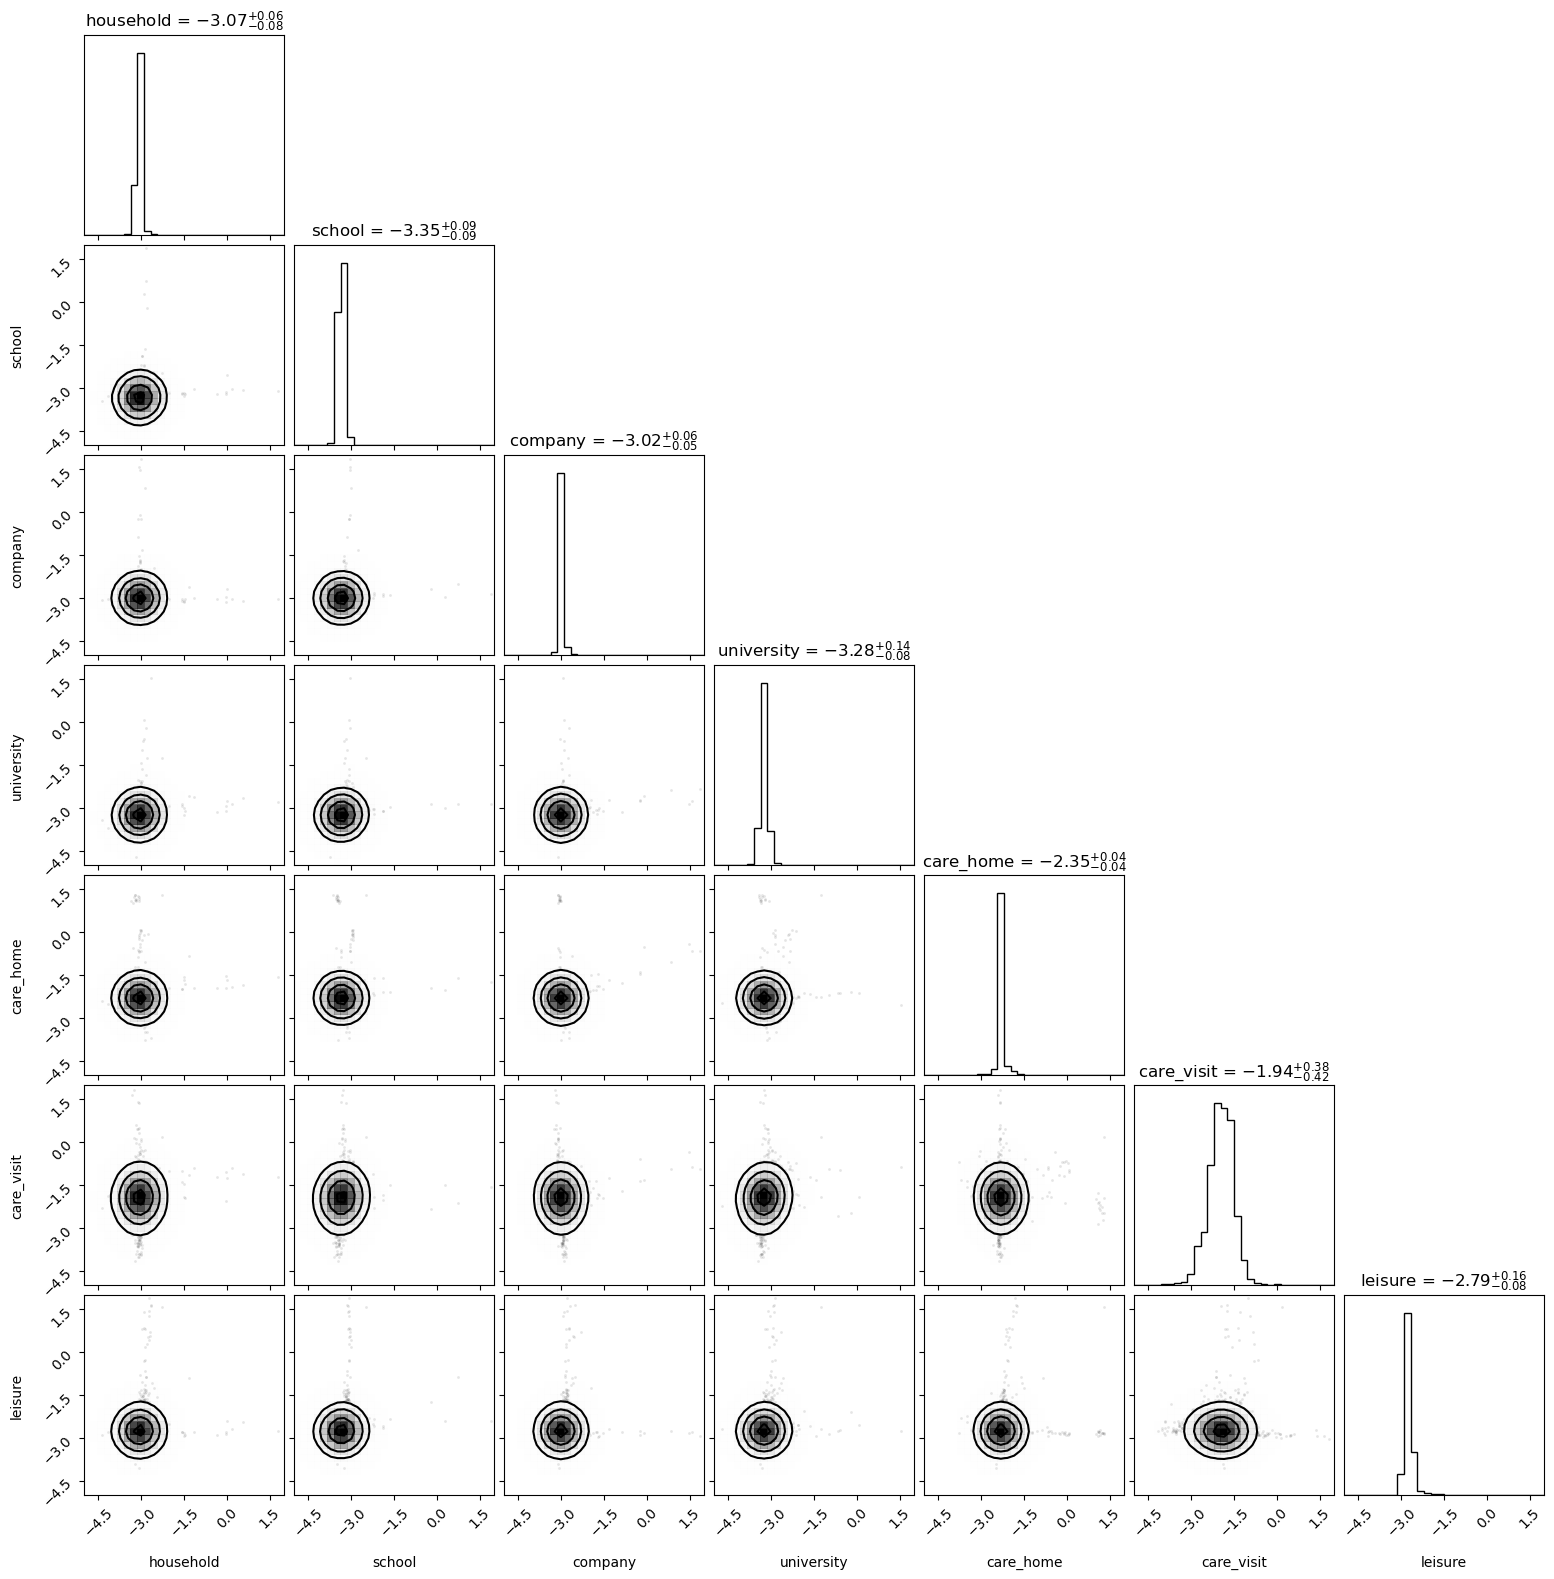

In [14]:
plot_posterior(flow, params_to_calibrate, lims=(-5, 2))

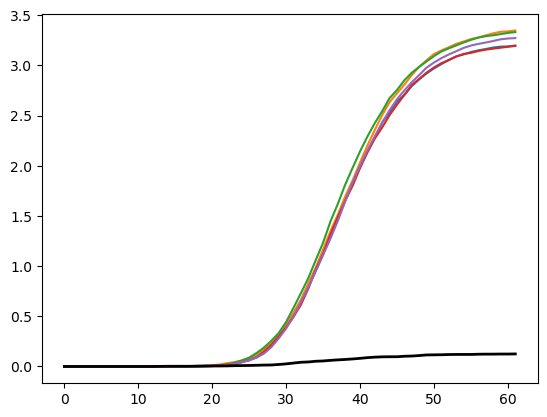

In [16]:
n_plot = 5
fig, ax = plt.subplots()

for i in range(n_plot):
    with torch.no_grad():
        params["system"]["device"] = device
        params["data_path"] = "/Users/arnull/code/gradabm-june/worlds/data_camden.pkl"
        runner = Runner.from_parameters(params)
        best_params_sample, log_prob = flow.sample()
        cases = run_model(runner, best_params_sample)
        ax.plot(cases.detach().cpu())

ax.plot(true_data.cpu(), color = "black", linewidth=2)
#ax.set_yscale("log")